# Udacity MLND Capstone Project 
## "Determination of students’ interaction patterns with an intelligent tutoring system and study of their correlation with successful learning"
### Step 1 (sensitivity check, run 1)

In [1]:
# Select test_size and random_state for splitting a subset
test_size=0.1
random_state=0

In [2]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import time
import gzip
import shutil
import seaborn as sns
from collections import Counter

from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans, MeanShift, estimate_bandwidth, AgglomerativeClustering
from sklearn.metrics import silhouette_score #, make_scorer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.neighbors import kneighbors_graph
from sklearn.model_selection import train_test_split

Do some preprocessing to group the data by `'Anon Stud Id'` and extract features for further analysis

In [3]:
def hdf_fixed_write_compress(df):
    df.to_hdf('data1-step1.hdf','test',mode='w',complib='blosc')
    return

def hdf_fixed_read_compress():
    df = pd.read_hdf('data.hdf','test')
    return df

In [4]:
with gzip.open('data1.hdf.gz', 'rb') as f_in, open('data.hdf', 'wb') as f_out:
    shutil.copyfileobj(f_in, f_out)

!ls -lh data.hdf

data = hdf_fixed_read_compress()
data.head()

-rw-rw-r-- 1 dima806 dima806 73M Nov  4 19:31 data.hdf


,Anon Student Id,Session Id,Duration (sec),Student Response Type,Problem Name,Problem View,Attempt At Step,Outcome,Day,x
0,Stu_001d187b1b375fe98b88696b250177f0,647501,102.0,1,2218,1.0,1.0,2.0,2004-11-10,0
1,Stu_001d187b1b375fe98b88696b250177f0,647501,46.0,0,2218,1.0,2.0,0.0,2004-11-10,1
2,Stu_001d187b1b375fe98b88696b250177f0,647792,70.0,1,3093,1.0,1.0,2.0,2004-11-10,0
3,Stu_001d187b1b375fe98b88696b250177f0,647792,22.0,1,3093,1.0,1.0,2.0,2004-11-10,0
4,Stu_001d187b1b375fe98b88696b250177f0,647792,2.0,1,3093,1.0,2.0,2.0,2004-11-10,0


**Note to reviewers**: this algorithm is quite slow (~45 minutes), so you may consider processing a substantial subset of data (e.g. processing 500,000 rows takes only ~1 minute).

In [5]:
def prepare_stud_data_new(df):

    start_time = time.time()
    stud_list = df['Anon Student Id'].unique()
    cols=['num_sess', \
          'num_days', \
          'num_probs', \
          'num_atts', \
          'num_hints', \
          'frac_corr_atts', \
          'frac_3s_atts', \
          'frac_1s_hints', \
          'time_atts', \
          'time_hints', \
          'max_probl_views', \
          'max_atts']
    
    numbers = []
    #stud_data = pd.DataFrame(columns=cols)
    stud_info_df = pd.DataFrame()
    i = 0
    for stud_name in stud_list:
        stud_info_df = df[df['Anon Student Id'] == stud_name].copy()

        # total number of days loading the system
        num_days = len(set(stud_info_df['Day']))

        # total number of sessions opened
        num_sessions = len(set(stud_info_df['Session Id']))

        # total number of problems entered
        num_problems = len(set(stud_info_df['Problem Name']))

        # total number of attempts made by the student 
        num_attempts = stud_info_df[stud_info_df['Student Response Type'] == 0].shape[0]

        # total number of hints made by the student 
        num_hints = stud_info_df[stud_info_df['Student Response Type'] == 1].shape[0]

        # fraction of short attemps (with time <= 3 sec)
        if (num_attempts > 0):
            frac_3s_atts = stud_info_df[(stud_info_df['Student Response Type'] == 0) & (stud_info_df['Duration (sec)'] <= 3.0)].shape[0] / num_attempts
        else:
            frac_3s_atts = 0

        # fraction of short hints (with time <= 1 sec)
        if (num_hints > 0):
            frac_1s_hints = stud_info_df[(stud_info_df['Student Response Type'] == 1) & (stud_info_df['Duration (sec)'] <= 1.0)].shape[0] / num_hints
        else:
            frac_1s_hints = 0

        # fraction of correct attempts
        if (num_attempts > 0):
            fraction_correct_attempts = stud_info_df[(stud_info_df['Student Response Type'] == 0) & (stud_info_df['Outcome'] == 0)].shape[0] / num_attempts
        else:
            fraction_correct_attempts = 0

        # total number of time spent for attempts (in seconds)
        total_time_attempts = stud_info_df[stud_info_df['Student Response Type'] == 0]['Duration (sec)'].sum()

        # total number of time spent for hints (in seconds)
        total_time_hints = stud_info_df[stud_info_df['Student Response Type'] == 1]['Duration (sec)'].sum()

        # averaged maximal numbers of 'Problem View'
        avg_max_problem_views = stud_info_df[['Problem Name', 'Problem View']].groupby(['Problem Name']).agg(np.max).mean()[0]

        # averaged maximal number of attempts ('x')
        avg_max_attempts = stud_info_df[['Problem Name', 'x']].groupby(['Problem Name']).agg(np.max).mean()[0]

        stud_name = i # assign unique numerical ID to each student 

        if num_attempts != 0:
            avd_time_att = total_time_attempts / num_attempts
        else:
            avg_time_att = 0
        if num_hints != 0:
            avg_time_hint = total_time_hints / num_hints
        else:
            avg_time_hint = 0 
        numbers.append([num_sessions, \
                                 num_days, \
                                 num_problems, \
                                 num_attempts, \
                                 num_hints, \
                                 fraction_correct_attempts, \
                                 frac_3s_atts, \
                                 frac_1s_hints, \
                                 total_time_attempts, \
                                 total_time_hints, \
                                 avg_max_problem_views, \
                                 avg_max_attempts])
        print("\r\t>>> Progress\t:{:.4%}".format((i + 1)/len(stud_list)), end='')
        i += 1
    stud_data = pd.DataFrame(data=numbers, columns=cols)
    end_time = time.time()
    print("\n\t>>> Exec. time\t:{}s".format(end_time-start_time))
    return stud_data

Reading from the scratch instead:

In [6]:
#stud_data = prepare_stud_data_new(data.head(500000).copy())
#stud_data = prepare_stud_data_new(data.copy())

stud_data = pd.read_hdf('stud_data.hdf','test')

Making backup for `stud_data` in HDF5 format:

In [7]:
#stud_data.to_hdf('stud_data.hdf','test',mode='w',complib='blosc')

In [8]:
stud_data.shape

(8980, 12)

In [9]:
stud_data.describe()

,num_sess,num_days,num_probs,num_atts,num_hints,frac_corr_atts,frac_3s_atts,frac_1s_hints,time_atts,time_hints,max_probl_views,max_atts
count,8980.000000,8980.000000,8980.000000,8980.000000,8980.000000,8980.000000,8980.000000,8980.000000,8980.000000,8980.000000,8980.000000,8980.000000
mean,76.158129,5.767038,62.234298,213.419933,89.186192,0.562803,0.046694,0.052563,7621.217689,1511.659815,1.191333,3.606050
std,88.289228,4.898646,64.666099,234.867659,147.576020,0.155490,0.075056,0.096731,7433.529297,1694.585366,0.364244,1.941819
min,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,13.000000,2.000000,11.000000,38.000000,9.000000,0.478962,0.000000,0.000000,1544.750000,273.000000,1.017241,2.433333
50%,44.000000,4.000000,40.000000,132.000000,32.000000,0.557991,0.021805,0.000000,5377.500000,893.000000,1.103175,3.319091
75%,110.000000,9.000000,95.000000,313.000000,105.000000,0.647806,0.061798,0.067568,11703.250000,2223.250000,1.244350,4.400000
max,1067.000000,55.000000,522.000000,2091.000000,2465.000000,1.000000,1.000000,1.000000,69259.000000,18370.000000,22.000000,46.000000


# Choosing a student subset for a sensitivity check
## (note that this step updates `stud_data`):

In [10]:
print(test_size, random_state)
stud_data_1, stud_data_2 = train_test_split(stud_data, test_size=test_size, random_state=random_state)

0.1 0


In [11]:
stud_data_1.shape[0]/stud_data.shape[0]

0.9

In [12]:
stud_data = stud_data_1

## Clustering

Write a new clustering algorithm that:
- starts from stud_data or its subset (with monotonic index)
- finds a 2-column set with the largest score (using KMeans) and renames it that 0 is the largest group, 1 is the second largest etc.
- returns index file (with indices 0, 1, ) that could be used for further analysis

In [13]:
# old name: process_data
def transform_data(selected_columns, data):
    '''
    Apply log-transform and MinMaxScaler() to the selected data columns which are not fractions (frac_*)
    
    Parameters
    ==========
    selected_columns : list
        list of columns to leave in processed data
    data : pandas.DataFrame
        data to process (note that data should contain all selected_columns)
        
    Returns
    =======
    log_scaled_data : pandas.DataFrame
        log-transformed and scaled data selected by selected_columns
    '''
    
    data.reset_index(drop=True, inplace=True)
    log_data = data[selected_columns].copy()
    
    skewed = log_data.columns.tolist()
    skewed = [item for item in skewed if not item.startswith('frac_')]
    log_data[skewed] = log_data[skewed].apply(lambda x: np.log10(x + 1))

    scaler = MinMaxScaler().fit(log_data)
    log_scaled_data = scaler.transform(log_data)
    log_scaled_data = pd.DataFrame(log_scaled_data, columns=log_data.columns)
    
    return log_scaled_data

In [14]:
def replace_group_numbers(best_preds):
    '''
    Replace group numbers in best_preds with sorting by group size 
    (so that the largest group is 0, the second largest is 1 etc.)
    
    Parameters
    ==========
    best_preds : numpy array
        unsorted array of predictions
    
    Returns
    =======
    best_preds_sorted : numpy array
        sorted array of predictions
    '''
    
    pp = pd.DataFrame(best_preds, columns = ["old_group"])
    dict_pp = {item[0]: i for i, item in enumerate(Counter(best_preds).most_common())}
    pp['new_group'] = pp['old_group'].replace(dict_pp)
    best_preds_sorted = np.array(pp['new_group'])
    return best_preds_sorted

In [15]:
def kmeans(log_scaled_data):
    '''
    Apply KMeans clustering algorithm with 2 <= cluster_number <= 6 to log_scaled_data 
    (transformed and scaled by transform_data() function)
    
    Parameters
    ==========
    log_scaled_data : pandas.DataFrame
        data log-transormed and MinMaxScaler()-ed for KMeans clustering
    
    Returns
    =======
    best_clusterer : sklearn Model
        clustering algorithm with the largest Silhouette Coefficient
    best_score : float
        the largest value of the Silhouette Coefficient
    best_preds_sorted : numpy.array
        array with clustering predictions for log_scaled_data 
        (0 is the largest cluster, 1 is the second largest etc.) 
    '''
    
    best_score = 0
    for n_clusters in range(2,6):
        clusterer = KMeans(n_clusters=n_clusters, n_init=10, random_state=0)
        clusterer.fit(log_scaled_data)
        preds = clusterer.predict(log_scaled_data)
        # Calculate the mean silhouette coefficient for the number of clusters chosen
        score = silhouette_score(log_scaled_data, preds)
        if best_score < score:
            best_clusterer = clusterer
            # Predict the cluster for each data point
            best_preds = best_clusterer.predict(log_scaled_data)
            best_score = score
            best_clusters = n_clusters
    best_preds_sorted = replace_group_numbers(best_preds)
    
    return best_clusterer, best_score, best_preds_sorted

Choose the pair of columns with best score:

In [16]:
all_columns = ['num_sess', 'num_days', 'num_probs', 'num_atts', 'num_hints', 'frac_corr_atts', \
                   'frac_3s_atts', 'frac_1s_hints', 'time_atts', 'time_hints', 'max_probl_views', 'max_atts']

In [17]:
def choose_pair_columns_kmeans(all_columns, log_scaled_all_data):
    '''
    Selects pair of columns in data that produces clusters with the largest score.
    In this function, only KMeans clustering algorithm is used

    Parameters
    ==========
    all_columns : list 
        list of columns to look for the pair with the largest score
    log_scaled_data : pandas DataFrame
        properly scaled DataFrame with all columns

    Returns
    =======
    best_columns : list
        pair of data columns with the largest score
    best_score : float
        the largest value of the score
    best_clusterer : sklearn Model
        clustering algorithm with the largest score
    best_preds : numpy.array
        array with clustering predictions for log_scaled_data 
        (0 is the largest cluster, 1 is the second largest etc.)    
    '''
    
    best_score = 0
    best_columns = []
    j = 0
    l = len(all_columns)
    num_pairs = (l-1)*l/2
    for column in all_columns:
        selected_columns = [column]
        
        columns_to_add = [a for a in all_columns if (a not in selected_columns)]
        for column1 in columns_to_add:
            if all_columns.index(column) < all_columns.index(column1):
                selected_columns = [column, column1]
                print("\r\t>>> Progress\t:{:.4%}".format((j+1)/num_pairs), end='')
                j += 1       
                #log_scaled_data = transform_data(selected_columns, stud_data)
                clusterer, score, preds = kmeans(log_scaled_all_data[selected_columns])
                if score > best_score:
                    best_score = score
                    best_clusterer = clusterer
                    best_preds = preds
                    best_columns = selected_columns.copy()
    
    return best_columns, best_score, best_clusterer, best_preds

In [18]:
start_time = time.time()
log_scaled_all_data = transform_data(all_columns, stud_data)

# consider skipping the step below because it takes some time (~5 minutes)
best_columns, best_kmeans_score, best_kmeans_clusterer, best_kmeans_preds = choose_pair_columns_kmeans(all_columns, log_scaled_all_data)

# Instead run it single time (6 seconds only)
#best_columns = ['frac_1s_hints', 'max_probl_views']
#best_kmeans_clusterer, best_kmeans_score, best_kmeans_preds = kmeans(log_scaled_all_data[best_columns]) 

end_time = time.time()
print("\n\t>>> Exec. time\t:{}s".format(end_time-start_time))
print("\t>>> Best pair of cols:", best_columns)
print("\t>>> Best score:", best_kmeans_score)
print("\t>>> Best clusterer:", best_kmeans_clusterer)
print("\t>>> Best preds:", best_kmeans_preds)

	>>> Progress	:100.0000%
	>>> Exec. time	:338.55461382865906s
	>>> Best pair of cols: ['frac_1s_hints', 'max_probl_views']
	>>> Best score: 0.695305620538
	>>> Best clusterer: KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=2, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=0, tol=0.0001, verbose=0)
	>>> Best preds: [0 1 0 ..., 0 0 0]


In [19]:
def preds_to_indices(preds): # gives array and returns array of indices with 1s
    new_list = []
    for i, val in enumerate(preds):
        if val == 1:
            new_list.append(i)
    return np.array(new_list)

Visualising the KMeans clusters:

In [20]:
log_scaled_all_data.describe()

,num_sess,num_days,num_probs,num_atts,num_hints,frac_corr_atts,frac_3s_atts,frac_1s_hints,time_atts,time_hints,max_probl_views,max_atts
count,8082.000000,8082.000000,8082.000000,8082.000000,8082.000000,8082.000000,8082.000000,8082.000000,8082.000000,8082.000000,8082.000000,8082.000000
mean,0.469315,0.288675,0.505168,0.605533,0.437398,0.564002,0.046214,0.052035,0.739342,0.647136,0.034366,0.379198
std,0.211557,0.218539,0.230231,0.186698,0.207678,0.154890,0.073046,0.096875,0.137339,0.199939,0.045747,0.093183
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.309839,0.121681,0.321886,0.475758,0.294812,0.480000,0.000000,0.000000,0.658586,0.571315,0.002825,0.320386
50%,0.495751,0.274980,0.542614,0.639606,0.447676,0.558824,0.021765,0.000000,0.770838,0.692131,0.020476,0.379311
75%,0.639511,0.482995,0.695454,0.752272,0.597084,0.648276,0.061715,0.066667,0.840456,0.785237,0.047057,0.437680
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


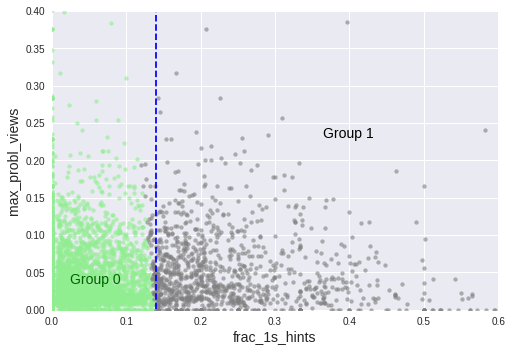

In [21]:
best_kmeans_preds_mask = preds_to_indices(best_kmeans_preds)
log_scaled_all_data_kmeans_0 = log_scaled_all_data.copy()[~log_scaled_all_data.index.isin(best_kmeans_preds_mask)]
log_scaled_all_data_kmeans_1 = log_scaled_all_data.copy()[log_scaled_all_data.index.isin(best_kmeans_preds_mask)]
plt.scatter(log_scaled_all_data_kmeans_0['frac_1s_hints'], \
            log_scaled_all_data_kmeans_0['max_probl_views'], \
            alpha=0.6, s=15, c='lightgreen')
plt.scatter(log_scaled_all_data_kmeans_1['frac_1s_hints'], \
            log_scaled_all_data_kmeans_1['max_probl_views'], \
            alpha=0.6, s=15, c='grey')
plt.xlim([0.0, 0.6])
plt.ylim([0.0, 0.4])
plt.figtext(x=0.64, y=0.56, s='Group 1', ha='center', size=14, color='black')
plt.figtext(x=0.20, y=0.19, s='Group 0', ha='center', size=14, color='darkgreen')
ax = plt.gca()
ax.set_xlabel('frac_1s_hints', size=14)
ax.set_ylabel('max_probl_views', size=14)
plt.plot((0.14, 0.14), (0.001, 0.399), 'k--', c='blue')
plt.show()

In [22]:
print(log_scaled_all_data_kmeans_0.shape, log_scaled_all_data_kmeans_1.shape)

(6934, 12) (1148, 12)


Then, consider adding one more column to further increase the score:

In [23]:
def cols_iterate_kmeans(selected_columns, best_score, best_clusterer, best_preds):

    all_columns = ['num_sess', 'num_days', 'num_probs', 'num_atts', \
                   'num_hints', 'frac_corr_atts', 'frac_3s_atts', 'frac_1s_hints', \
                   'time_atts', 'time_hints', 'max_probl_views', 'max_atts']

    columns_to_add = [a for a in all_columns if (a not in selected_columns)]
    #print(columns_to_add)
    for column in columns_to_add:
        print("*"*40)
        print("*** Trying to add column", column)
        print("*"*40)
        selected_columns.append(column)
        log_scaled_data = transform_data(selected_columns, stud_data)
        clusterer, score, preds = kmeans(log_scaled_data)
        if score > best_score:
            print("!!! Success !!!")
            best_score = score
            best_clusterer = clusterer
            best_preds = preds
            print("!!! New score is", best_score)
            print("!!! New best clusterer is", best_clusterer)
            print("!!! New best selected_columns are", selected_columns)
            columns_to_add.remove(column)
        else:
            print("!!! Last score is equal or worse then our best one")
            print("!!! According to Occam's razor, remove the column", column)
            selected_columns.remove(column)
            print("!!! Still the best selected columns are", selected_columns)
    return selected_columns, best_score, best_clusterer, best_preds

In [24]:
# Just skip this step, it does not give new results:

kmeans_clusterer = best_kmeans_clusterer
kmeans_score = best_kmeans_score
kmeans_preds = best_kmeans_preds

selected_columns = best_columns # ['frac_1s_hints', 'max_probl_views']
new_columns, new_kmeans_score, new_kmeans_clusterer, new_kmeans_preds = cols_iterate_kmeans(selected_columns, kmeans_score, kmeans_clusterer, kmeans_preds)
if new_kmeans_score > kmeans_score:
    print("+++ SUCCESS")
    selected_columns = new_columns
    best_kmeans_score = new_kmeans_score
    best_kmeans_clusterer = new_kmeans_clusterer
    best_kmeans_preds = new_kmeans_preds
else:
    print("--- GIVE UP")

****************************************
*** Trying to add column num_sess
****************************************
!!! Last score is equal or worse then our best one
!!! According to Occam's razor, remove the column num_sess
!!! Still the best selected columns are ['frac_1s_hints', 'max_probl_views']
****************************************
*** Trying to add column num_days
****************************************
!!! Last score is equal or worse then our best one
!!! According to Occam's razor, remove the column num_days
!!! Still the best selected columns are ['frac_1s_hints', 'max_probl_views']
****************************************
*** Trying to add column num_probs
****************************************
!!! Last score is equal or worse then our best one
!!! According to Occam's razor, remove the column num_probs
!!! Still the best selected columns are ['frac_1s_hints', 'max_probl_views']
****************************************
*** Trying to add column num_atts
**************

As expected, the pair ['frac_1s_hints', 'max_probl_views'] still gives the best score.

Now, trying with different clusterers.

MeanShift:

In [25]:
def largest_cluster_fraction(preds):
    '''
    calculates the fraction of students that are in the largest group
    
    Parameters
    ==========
    preds : list
        list of predictions
    
    Returns
    =======
    fraction : float
        largest fraction of students
    best_i : integer
        number of the largest group
    '''
    
    fraction = 0
    ll = len(preds)
    for i in np.unique(preds):
        frac = len(preds[preds == i])/ll
        if frac > fraction:
            fraction = frac
            best_i = i
    return fraction, best_i

# Rewrite similar to kmeans procedure !!!

def meanshift(log_scaled_data):
    '''
    Apply MeanShift clustering algorithm to log_scaled_data
    (transformed and scaled by transform_data() function)
    Number of clusters is selected according to estimate_badwidth procedure
    with quantiles in np.linspace(0.01, 0.99, 99)
    
    
    Parameters
    ==========
    log_scaled_data : pandas.DataFrame
        data log-transormed and MinMaxScaler()-ed for KMeans clustering
    
    Returns
    =======
    best_clusterer : sklearn Model
        clustering algorithm with the largest Silhouette Coefficient
    best_score : float
        the largest value of the Silhouette Coefficient
    best_preds_sorted : numpy.array
        array with clustering predictions for log_scaled_data 
        (0 is the largest cluster, 1 is the second largest etc.) 
    cluster_frac : float
        fraction of students inside the largest group
    '''

    start_time = time.time()
    best_score = 0
    best_cluster_frac = 0
    for alpha in np.linspace(0.01, 0.99, 99):
        bandwidth = estimate_bandwidth(log_scaled_data, quantile=alpha, n_samples=None, random_state=0)

        clusterer = MeanShift(bandwidth=bandwidth, bin_seeding=True)
        clusterer.fit(log_scaled_data)

        preds = clusterer.fit_predict(log_scaled_data)
        cluster_frac = largest_cluster_fraction(preds)[0]
        # Calculate the mean silhouette coefficient for the number of clusters chosen
        try: 
            score = silhouette_score(log_scaled_data, preds)
        except ValueError:
            score = 0
        print(alpha, clusterer.cluster_centers_.shape[0], score, cluster_frac)
        # setting cluster_frac > 0.85, the value obtained in KMeans algorithm for ['frac_1s_hints', 'max_probl_views']
        if (best_score < score) and (cluster_frac < 0.85):
            best_clusterer = clusterer
            best_preds = preds
            best_score = score
            best_clusters = clusterer.cluster_centers_.shape[0]
            best_cluster_frac = cluster_frac
    print('*'*68)
    print("Our best model has", best_clusters, "clusters and sihlouette is", best_score)
    end_time = time.time()
    print("Running time is {}s".format(end_time-start_time))
    print('>'*68)
    best_preds_sorted = replace_group_numbers(best_preds)
    cluster_frac = best_cluster_frac
    
    return best_clusterer, best_score, best_preds_sorted, cluster_frac

# Rinning MeanShift is too slow: runs about 9 min for 1 pair, 
# and produces too bad results (largest score = 0.56 for reasonable max_fractions < 0.85)

start_time = time.time()
log_scaled_data = transform_data(best_columns, stud_data)
best_meanshift_clusterer, best_meanshift_score, best_meanshift_preds, _ = meanshift(log_scaled_data)
print(best_meanshift_clusterer, best_meanshift_score, best_meanshift_preds)
end_time = time.time()
print("Running time is {}s".format(end_time-start_time))

0.01 228 0.500181896189 0.2564959168522643
0.02 134 0.404381577676 0.4083147735708983
0.03 94 0.404325377844 0.4378866617173967
0.04 74 0.423126107413 0.47376886909180893
0.05 58 0.499145031119 0.720613709477852
0.06 50 0.507429382419 0.7358327146745856
0.07 46 0.526674984397 0.7475872308834447
0.08 41 0.543531056831 0.7546399406087602
0.09 36 0.547428620596 0.7736946300420688
0.1 34 0.532915230918 0.8019054689433308
0.11 33 0.530578118491 0.8038851769364019
0.12 31 0.510792191991 0.8083395199208117
0.13 27 0.524016436634 0.8630289532293987
0.14 23 0.533531351363 0.8544914625092799
0.15 25 0.555516796425 0.8475624845335313
0.16 23 0.544375901969 0.8546151942588468
0.17 22 0.554216786274 0.852264291017075
0.18 22 0.544916385172 0.8533778767631774
0.19 20 0.553079307387 0.8580796832467211
0.2 18 0.55185189299 0.8538728037614451
0.21 15 0.621485193863 0.8850532046523137
0.22 14 0.639573715993 0.8921059143776293
0.23 14 0.636543532297 0.89086859688196
0.24 13 0.594053561153 0.9159861420440

GaussianMixture:

In [26]:
def gaussmix(log_scaled_data): # GaussianMixture
    start_time = time.time()
    max_score = 0
    for n_clusters in range(2,6):

        clusterer = GaussianMixture(random_state=0, n_init=50, n_components=n_clusters).fit(log_scaled_data)

        preds = clusterer.predict(log_scaled_data)
    # Calculate the mean silhouette coefficient for the number of clusters chosen
        score = silhouette_score(log_scaled_data, preds)
        print("For our model with", clusterer.n_components, "clusters, the sihlouette score is", score)
        if max_score < score:
            best_clusterer = clusterer
            # Predict the cluster for each data point
            best_preds = best_clusterer.predict(log_scaled_data)
            max_score = score
            best_clusters = n_clusters
    print('*'*68)
    print("Our best model has", best_clusters, "clusters and sihlouette is", max_score)
    end_time = time.time()
    print("Running time is {}s".format(end_time-start_time))
    print('>'*68)
    best_preds_sorted = replace_group_numbers(best_preds)
    return best_clusterer, max_score, best_preds_sorted

def run_clustering_gaussmix(log_scaled_data):
    best_score = 0
    print(">>> GaussianMixture:")
    clusterer, score, preds = gaussmix(log_scaled_data)
    if score > best_score:
        best_clusterer = clusterer
        best_score = score
        best_preds = preds
    print("Best clusterer is", best_clusterer)
    print("Max score is", best_score)
    print("Best preds is", best_preds)
    return best_clusterer, best_score, best_preds

# ~0.6 min running time but very small score (~0.39)
start_time = time.time()
log_scaled_data = transform_data(best_columns, stud_data)
gaussmix_best_clusterer, gaussmix_best_score, gaussmix_best_preds = run_clustering_gaussmix(log_scaled_data)
print(gaussmix_best_clusterer, gaussmix_best_score, gaussmix_best_preds)
end_time = time.time()
print("Running time is {}s".format(end_time-start_time))

>>> GaussianMixture:
For our model with 2 clusters, the sihlouette score is 0.358472814577
For our model with 3 clusters, the sihlouette score is 0.373147556516
For our model with 4 clusters, the sihlouette score is 0.368425054857
For our model with 5 clusters, the sihlouette score is 0.391486465682
********************************************************************
Our best model has 5 clusters and sihlouette is 0.391486465682
Running time is 20.204499006271362s
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Best clusterer is GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
        means_init=None, n_components=5, n_init=50, precisions_init=None,
        random_state=0, reg_covar=1e-06, tol=0.001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)
Max score is 0.391486465682
Best preds is [2 2 1 ..., 1 1 0]
GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
        means_init=None, n_c

AgglomerativeClustering:

In [27]:
def agglom(log_scaled_data): # AgglomerativeClustering with 'ward' connectivity
    start_time = time.time()
    max_score = 0
    for n_clusters in range(2,3): # use only 2 clusters
        connectivity = kneighbors_graph(log_scaled_data, n_neighbors=100, include_self=False)
        # make connectivity symmetric
        connectivity = 0.5 * (connectivity + connectivity.T)
        clusterer = AgglomerativeClustering(n_clusters=n_clusters, \
                                          linkage='ward', \
                                          connectivity=connectivity)

        preds = clusterer.fit_predict(log_scaled_data)
        # Calculate the mean silhouette coefficient for the number of clusters chosen
        score = silhouette_score(log_scaled_data, preds)
        print("For our model with", clusterer.n_clusters, "clusters, and the sihlouette score is", score)
        if max_score < score:
            best_clusterer = clusterer
            # Predict the cluster for each data point
            best_preds = preds
            max_score = score
            best_clusters = n_clusters
    print('*'*68)
    print("Our best model has", best_clusters, "clusters and sihlouette is", max_score)
    end_time = time.time()
    print("Running time is {}s".format(end_time-start_time))
    print('>'*68)
    best_preds_sorted = replace_group_numbers(best_preds)
    return best_clusterer, max_score, best_preds_sorted

def run_clustering_agglom(log_scaled_data):
    best_score = 0
    print(">>> AgglomerativeClustering:")
    clusterer, score, preds = agglom(log_scaled_data)
    if score > best_score:
        best_clusterer = clusterer
        best_score = score
        best_preds = preds
    print("Best clusterer is", best_clusterer)
    print("Max score is", best_score)
    print("Best preds is", best_preds)
    return best_clusterer, best_score, best_preds

# Gives results very similar to KMeans but takes ~4 times more running time
start_time = time.time()
log_scaled_data = transform_data(best_columns, stud_data)
best_agglom_clusterer, best_agglom_score, best_agglom_preds = run_clustering_agglom(log_scaled_data)
print(best_agglom_clusterer, best_agglom_score, best_agglom_preds)
end_time = time.time()
print("Running time is {}s".format(end_time-start_time))

>>> AgglomerativeClustering:
For our model with 2 clusters, and the sihlouette score is 0.693660541155
********************************************************************
Our best model has 2 clusters and sihlouette is 0.693660541155
Running time is 10.991336822509766s
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Best clusterer is AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
            connectivity=<8082x8082 sparse matrix of type '<class 'numpy.float64'>'
	with 1065816 stored elements in Compressed Sparse Row format>,
            linkage='ward', memory=None, n_clusters=2,
            pooling_func=<function mean at 0x7fc1802676a8>)
Max score is 0.693660541155
Best preds is [0 1 0 ..., 0 0 0]
AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
            connectivity=<8082x8082 sparse matrix of type '<class 'numpy.float64'>'
	with 1065816 stored elements in Compressed Sparse Row format>,
            linkage='ward'

Visualising the AgglomerativeClustering clusters:

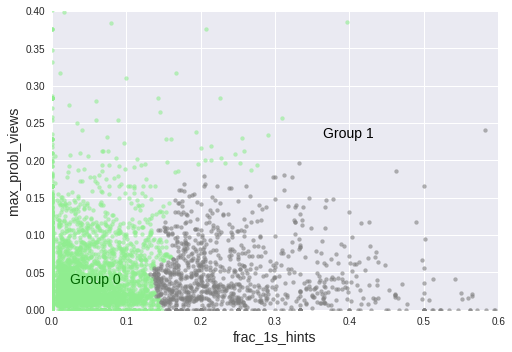

In [28]:
best_agglom_preds_mask = preds_to_indices(best_agglom_preds)
log_scaled_data_agglom_0 = log_scaled_data.copy()[~log_scaled_data.index.isin(best_agglom_preds_mask)]
log_scaled_data_agglom_1 = log_scaled_data.copy()[log_scaled_data.index.isin(best_agglom_preds_mask)]
plt.scatter(log_scaled_data_agglom_0['frac_1s_hints'], \
            log_scaled_data_agglom_0['max_probl_views'], \
            alpha=0.6, s=15, c='lightgreen')
plt.scatter(log_scaled_data_agglom_1['frac_1s_hints'], \
            log_scaled_data_agglom_1['max_probl_views'], \
            alpha=0.6, s=15, c='grey')
plt.xlim([0.0, 0.6])
plt.ylim([0.0, 0.4])
plt.figtext(x=0.64, y=0.56, s='Group 1', ha='center', size=14, color='black')
plt.figtext(x=0.20, y=0.19, s='Group 0', ha='center', size=14, color='darkgreen')
ax = plt.gca()
ax.set_xlabel('frac_1s_hints', size=14)
ax.set_ylabel('max_probl_views', size=14)
#plt.plot((0.145, 0.145), (0.001, 0.399), 'k--', c='blue')
plt.show()

# Further clustering of obtained KMeans groups:

I start from group 0 that contains 6934 students:

In [29]:
best_kmeans_preds_mask = preds_to_indices(best_kmeans_preds)
log_scaled_all_data_kmeans_0 = log_scaled_all_data.copy()[~log_scaled_all_data.index.isin(best_kmeans_preds_mask)]

# In this particular splitting, take drop=False to save the initial index
# (simplifying students recovery for step 2)
log_scaled_all_data_kmeans_0.reset_index(inplace=True, drop=False)

log_scaled_all_data_kmeans_0.index

RangeIndex(start=0, stop=6934, step=1)

In [30]:
start_time = time.time()

best_kmeans_columns_0, \
best_kmeans_score_0, \
best_kmeans_clusterer_0, \
best_kmeans_preds_0 = choose_pair_columns_kmeans(all_columns, log_scaled_all_data_kmeans_0)

# best_kmeans_columns_0 = ['frac_3s_atts', 'max_probl_views']
# best_kmeans_clusterer_0, best_kmeans_score_0, best_kmeans_preds_0 = kmeans(log_scaled_all_data_kmeans_0[best_kmeans_columns_0]) 

end_time = time.time()
print("\n\t>>> Exec. time\t:{}s".format(end_time-start_time))
print("\t>>> Best pair of cols:", best_kmeans_columns_0)
print("\t>>> Best score:", best_kmeans_score_0)
print("\t>>> Best clusterer:", best_kmeans_clusterer_0)
print("\t>>> Best preds:", best_kmeans_preds_0)

	>>> Progress	:100.0000%
	>>> Exec. time	:230.62512516975403s
	>>> Best pair of cols: ['frac_3s_atts', 'max_probl_views']
	>>> Best score: 0.678149663001
	>>> Best clusterer: KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=2, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=0, tol=0.0001, verbose=0)
	>>> Best preds: [1 0 0 ..., 0 0 0]


In [31]:
print(sum(best_kmeans_preds_0), len(best_kmeans_preds_0), len(best_kmeans_preds_0[best_kmeans_preds_0 == 0]))

451 6934 6483


In [32]:
log_scaled_all_data_kmeans_0.reset_index(inplace=True, drop=True)


Visualise obtained clusters:

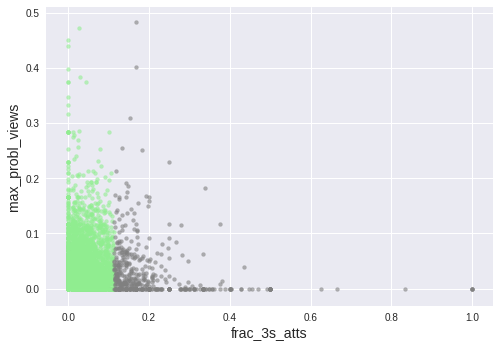

In [33]:
best_kmeans_preds_mask_0 = preds_to_indices(best_kmeans_preds_0)

log_scaled_all_data_kmeans_00 = log_scaled_all_data_kmeans_0.copy()[~log_scaled_all_data_kmeans_0.index.isin(best_kmeans_preds_mask_0)]

log_scaled_all_data_kmeans_01 = log_scaled_all_data_kmeans_0.copy()[log_scaled_all_data_kmeans_0.index.isin(best_kmeans_preds_mask_0)]

plt.scatter(log_scaled_all_data_kmeans_00[best_kmeans_columns_0[0]], \
            log_scaled_all_data_kmeans_00[best_kmeans_columns_0[1]], \
            alpha=0.6, s=15, c='lightgreen')
plt.scatter(log_scaled_all_data_kmeans_01[best_kmeans_columns_0[0]], \
            log_scaled_all_data_kmeans_01[best_kmeans_columns_0[1]], \
            alpha=0.6, s=15, c='grey')
# plt.xlim([0.0, 0.6])
# plt.ylim([0.0, 0.4])
# plt.figtext(x=0.64, y=0.56, s='Group 01', ha='center', size=14, color='black')
# plt.figtext(x=0.20, y=0.69, s='Group 00', ha='center', size=14, color='darkgreen')
ax = plt.gca()
ax.set_xlabel(best_kmeans_columns_0[0], size=14)
ax.set_ylabel(best_kmeans_columns_0[1], size=14)
#plt.plot((0.13, 0.13), (0.001, 0.499), 'k--', c='blue')
plt.show()

As we see, group 01 contains more students with "gaming" behaviour, so I proceed with group 00:

In [34]:
len(best_kmeans_preds_0)

6934

In [35]:
#best_kmeans_preds_mask_0 = preds_to_indices(best_kmeans_preds_0) # already implemented during group0 visualisation
log_scaled_all_data_kmeans_00 = log_scaled_all_data_kmeans_0.copy()[~log_scaled_all_data_kmeans_0.index.isin(best_kmeans_preds_mask_0)]

log_scaled_all_data_kmeans_00.reset_index(inplace=True, drop=True)

log_scaled_all_data_kmeans_00.index

RangeIndex(start=0, stop=6483, step=1)

In [36]:
start_time = time.time()

best_kmeans_columns_00, \
best_kmeans_score_00, \
best_kmeans_clusterer_00, \
best_kmeans_preds_00 = choose_pair_columns_kmeans(all_columns, log_scaled_all_data_kmeans_00)

# best_kmeans_columns_00 = ['frac_3s_atts', 'time_hints']
# best_kmeans_clusterer_00, \
# best_kmeans_score_00, \
# best_kmeans_preds_00 = kmeans(log_scaled_all_data_kmeans_00[best_kmeans_columns_00]) 


end_time = time.time()
print("\n\t>>> Exec. time\t:{}s".format(end_time-start_time))
print("\t>>> Best pair of cols:", best_kmeans_columns_00)
print("\t>>> Best score:", best_kmeans_score_00)
print("\t>>> Best clusterer:", best_kmeans_clusterer_00)
print("\t>>> Best preds:", best_kmeans_preds_00)

	>>> Progress	:100.0000%
	>>> Exec. time	:200.34948873519897s
	>>> Best pair of cols: ['frac_3s_atts', 'time_hints']
	>>> Best score: 0.641882416977
	>>> Best clusterer: KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=2, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=0, tol=0.0001, verbose=0)
	>>> Best preds: [0 0 0 ..., 0 0 0]


In [37]:
print(sum(best_kmeans_preds_00), len(best_kmeans_preds_00), len(best_kmeans_preds_00[best_kmeans_preds_00 == 0]))

1001 6483 5482


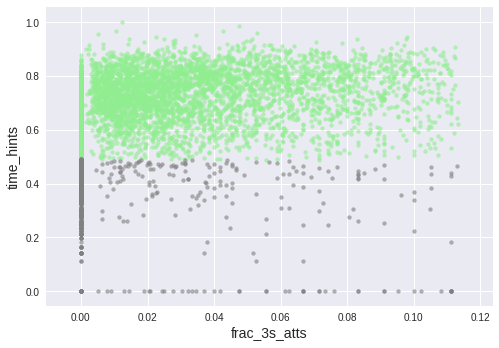

In [38]:
best_kmeans_preds_mask_00 = preds_to_indices(best_kmeans_preds_00)

log_scaled_all_data_kmeans_000 = log_scaled_all_data_kmeans_00.copy()[~log_scaled_all_data_kmeans_00.index.isin(best_kmeans_preds_mask_00)]

log_scaled_all_data_kmeans_001 = log_scaled_all_data_kmeans_00.copy()[log_scaled_all_data_kmeans_00.index.isin(best_kmeans_preds_mask_00)]

plt.scatter(log_scaled_all_data_kmeans_000[best_kmeans_columns_00[0]], \
            log_scaled_all_data_kmeans_000[best_kmeans_columns_00[1]], \
            alpha=0.6, s=15, c='lightgreen')
plt.scatter(log_scaled_all_data_kmeans_001[best_kmeans_columns_00[0]], \
            log_scaled_all_data_kmeans_001[best_kmeans_columns_00[1]], \
            alpha=0.6, s=15, c='grey')
# plt.xlim([0.0, 0.6])
# plt.ylim([0.0, 0.4])
# plt.figtext(x=0.64, y=0.56, s='Group 01', ha='center', size=14, color='black')
# plt.figtext(x=0.20, y=0.69, s='Group 00', ha='center', size=14, color='darkgreen')
ax = plt.gca()
ax.set_xlabel(best_kmeans_columns_00[0], size=14)
ax.set_ylabel(best_kmeans_columns_00[1], size=14)
#plt.plot((0.13, 0.13), (0.001, 0.499), 'k--', c='blue')
plt.show()

So, there is a subgroup 001 of 1001 students that do not use many hints. What about the rest (000, 5482 students)?

In [39]:
log_scaled_all_data_kmeans_000 = log_scaled_all_data_kmeans_00.copy()[~log_scaled_all_data_kmeans_00.index.isin(best_kmeans_preds_mask_00)]

log_scaled_all_data_kmeans_000.reset_index(inplace=True, drop=True)

log_scaled_all_data_kmeans_000.index

RangeIndex(start=0, stop=5482, step=1)

In [40]:
start_time = time.time()

best_kmeans_columns_000, \
best_kmeans_score_000, \
best_kmeans_clusterer_000, \
best_kmeans_preds_000 = choose_pair_columns_kmeans(all_columns, log_scaled_all_data_kmeans_000)

# best_kmeans_columns_000 = ['num_sess', 'num_probs']
# best_kmeans_clusterer_000, \
# best_kmeans_score_000, \
# best_kmeans_preds_000 = kmeans(log_scaled_all_data_kmeans_000[best_kmeans_columns_000]) 

end_time = time.time()
print("\n\t>>> Exec. time\t:{}s".format(end_time-start_time))
print("\t>>> Best pair of cols:", best_kmeans_columns_000)
print("\t>>> Best score:", best_kmeans_score_000)
print("\t>>> Best clusterer:", best_kmeans_clusterer_000)
print("\t>>> Best preds:", best_kmeans_preds_000)

	>>> Progress	:100.0000%
	>>> Exec. time	:146.4211826324463s
	>>> Best pair of cols: ['num_sess', 'num_probs']
	>>> Best score: 0.604208435858
	>>> Best clusterer: KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=2, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=0, tol=0.0001, verbose=0)
	>>> Best preds: [0 0 1 ..., 0 0 0]


In [41]:
print(sum(best_kmeans_preds_000), len(best_kmeans_preds_000), len(best_kmeans_preds_000[best_kmeans_preds_000 == 0]))

2151 5482 3331


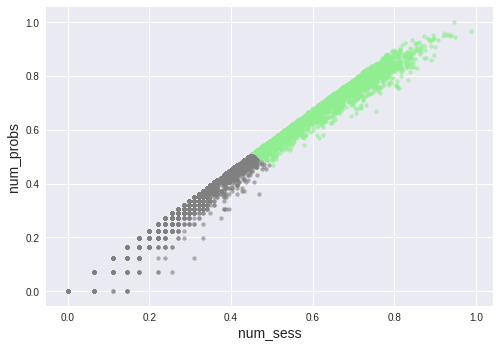

In [42]:
best_kmeans_preds_mask_000 = preds_to_indices(best_kmeans_preds_000)

log_scaled_all_data_kmeans_0000 = log_scaled_all_data_kmeans_000.copy()[~log_scaled_all_data_kmeans_000.index.isin(best_kmeans_preds_mask_000)]

log_scaled_all_data_kmeans_0001 = log_scaled_all_data_kmeans_000.copy()[log_scaled_all_data_kmeans_000.index.isin(best_kmeans_preds_mask_000)]

plt.scatter(log_scaled_all_data_kmeans_0000[best_kmeans_columns_000[0]], \
            log_scaled_all_data_kmeans_0000[best_kmeans_columns_000[1]], \
            alpha=0.6, s=15, c='lightgreen')
plt.scatter(log_scaled_all_data_kmeans_0001[best_kmeans_columns_000[0]], \
            log_scaled_all_data_kmeans_0001[best_kmeans_columns_000[1]], \
            alpha=0.6, s=15, c='grey')
# plt.figtext(x=0.64, y=0.56, s='Group 01', ha='center', size=14, color='black')
# plt.figtext(x=0.20, y=0.69, s='Group 00', ha='center', size=14, color='darkgreen')
ax = plt.gca()
ax.set_xlabel(best_kmeans_columns_000[0], size=14)
ax.set_ylabel(best_kmeans_columns_000[1], size=14)
#plt.plot((0.13, 0.13), (0.001, 0.499), 'k--', c='blue')
plt.show()

Splitting group 0000 (students with large `'num_sess'` and `'num_probs'`)

In [43]:
log_scaled_all_data_kmeans_0000 = log_scaled_all_data_kmeans_000.copy()[~log_scaled_all_data_kmeans_000.index.isin(best_kmeans_preds_mask_000)]

log_scaled_all_data_kmeans_0000.reset_index(inplace=True, drop=True)

log_scaled_all_data_kmeans_0000.index

RangeIndex(start=0, stop=3331, step=1)

In [44]:
start_time = time.time()

best_kmeans_columns_0000, \
best_kmeans_score_0000, \
best_kmeans_clusterer_0000, \
best_kmeans_preds_0000 = choose_pair_columns_kmeans(all_columns, log_scaled_all_data_kmeans_0000)

# best_kmeans_columns_0000 = ['num_sess', 'num_probs']
# best_kmeans_clusterer_0000, \
# best_kmeans_score_0000, \
# best_kmeans_preds_0000 = kmeans(log_scaled_all_data_kmeans_0000[best_kmeans_columns_0000]) 

end_time = time.time()
print("\n\t>>> Exec. time\t:{}s".format(end_time-start_time))
print("\t>>> Best pair of cols:", best_kmeans_columns_0000)
print("\t>>> Best score:", best_kmeans_score_0000)
print("\t>>> Best clusterer:", best_kmeans_clusterer_0000)
print("\t>>> Best preds:", best_kmeans_preds_0000)

	>>> Progress	:100.0000%
	>>> Exec. time	:59.218446254730225s
	>>> Best pair of cols: ['num_sess', 'num_probs']
	>>> Best score: 0.566278866518
	>>> Best clusterer: KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=2, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=0, tol=0.0001, verbose=0)
	>>> Best preds: [1 0 1 ..., 0 1 0]


In [45]:
print(sum(best_kmeans_preds_0000), \
      len(best_kmeans_preds_0000), \
      len(best_kmeans_preds_0000[best_kmeans_preds_0000 == 0]))

1597 3331 1734


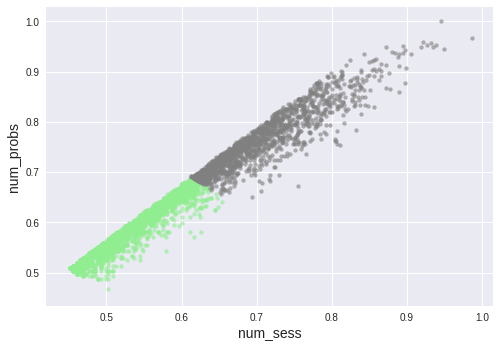

In [46]:
best_kmeans_preds_mask_0000 = preds_to_indices(best_kmeans_preds_0000)

log_scaled_all_data_kmeans_00000 = log_scaled_all_data_kmeans_0000.copy()[~log_scaled_all_data_kmeans_0000.index.isin(best_kmeans_preds_mask_0000)]

log_scaled_all_data_kmeans_00001 = log_scaled_all_data_kmeans_0000.copy()[log_scaled_all_data_kmeans_0000.index.isin(best_kmeans_preds_mask_0000)]

plt.scatter(log_scaled_all_data_kmeans_00000[best_kmeans_columns_0000[0]], \
            log_scaled_all_data_kmeans_00000[best_kmeans_columns_0000[1]], \
            alpha=0.6, s=15, c='lightgreen')
plt.scatter(log_scaled_all_data_kmeans_00001[best_kmeans_columns_0000[0]], \
            log_scaled_all_data_kmeans_00001[best_kmeans_columns_0000[1]], \
            alpha=0.6, s=15, c='grey')
# plt.xlim([0.0, 0.6])
# plt.ylim([0.0, 0.4])
# plt.figtext(x=0.64, y=0.56, s='Group 01', ha='center', size=14, color='black')
# plt.figtext(x=0.20, y=0.69, s='Group 00', ha='center', size=14, color='darkgreen')
ax = plt.gca()
ax.set_xlabel(best_kmeans_columns_0000[0], size=14)
ax.set_ylabel(best_kmeans_columns_0000[1], size=14)
#plt.plot((0.13, 0.13), (0.001, 0.499), 'k--', c='blue')
plt.show()

As we see, these two groups represent students with "intermediate experience" (00000) and "largest experience" (00001).

During this sensitivity check, I splitted 8082 students (90% of ASSISTments students) into 6 different groups:
- **group 1**, 1148 students with large `'frac_1s_hints'` ("gaming" behaviour);
- **group 2**, 451 students with small `'frac_1s_hints'` and large `'frac_3s_atts'` ("gaming" behaviour);
- **group 3**, 1001 students with small `'time_hints'` ("non-gaming" behaviour, small usage of hints);
- **group 4**, 2151 students with small `'num_sess'` and `'num_probs'` ("non-gaming" behaviour, large usage of hints, small experience);
- **group 5**, 1734 students with medium `'num_sess'` and `'num_probs'` ("non-gaming" behaviour, large usage of hints, medium experience);
- **group 6**, 1597 students with large `'num_sess'` and `'num_probs'` ("non-gaming" behaviour, large usage of hints, large experience).

The final result of this step is the joint cluster index that contains numbers 1-6 for each student:

In [47]:
group1_index = np.array(log_scaled_all_data_kmeans_1.index)
len(group1_index)

1148

In [48]:
group2_index = np.array(log_scaled_all_data_kmeans_01['index'])
len(group2_index)

451

In [49]:
group3_index = np.array(log_scaled_all_data_kmeans_001['index'])
len(group3_index)

1001

In [50]:
group4_index = np.array(log_scaled_all_data_kmeans_0001['index'])
len(group4_index)

2151

In [51]:
group5_index = np.array(log_scaled_all_data_kmeans_00000['index'])
len(group5_index)

1734

In [52]:
group6_index = np.array(log_scaled_all_data_kmeans_00001['index'])
len(group6_index)

1597

In [53]:
def create_joint_cluster_index():
    '''
    Saves group index files into cluster_index.csv for further analysis
    '''
    
    cluster_index_lst = []
    for i in range(len(stud_data)+1):
        if i in group1_index:
            cluster_index_lst.append(1)
        elif i in group2_index:
            cluster_index_lst.append(2)
        elif i in group3_index:
            cluster_index_lst.append(3)
        elif i in group4_index:
            cluster_index_lst.append(4)
        elif i in group5_index:
            cluster_index_lst.append(5)
        elif i in group6_index:
            cluster_index_lst.append(6)

    print(Counter(cluster_index_lst))
    cluster_index = pd.Series(cluster_index_lst, dtype=int)
    cluster_index.to_csv('cluster_index_run1.csv')
    return 

In [54]:
create_joint_cluster_index()

Counter({4: 2151, 5: 1734, 6: 1597, 1: 1148, 3: 1001, 2: 451})


In [55]:
! ls -lh cluster_index_run1.csv

-rw-rw-r-- 1 dima806 dima806 55K Nov  4 19:58 cluster_index_run1.csv
